# TYPE LABEL PROPAGATION (NEIGHBOR CRITERIA - NORMALIZED GRAPH)
**Aim :** Propagate the type of website (controversial or confident) as a label over the graph.  
**Remark :** We will use only normalized graph in this notebook

# LIBRARIES

In [1]:
import os
import os.path
os.chdir("C:/Users/maell/Fake_News_Project")

import urllib.request
import zipfile

import pandas as pd
import numpy as np
import community

from scipy import *

from itertools import combinations
from collections import Counter

#import matplotlib.pyplot as plt

from tqdm import tqdm

import networkx as nx

%matplotlib inline

# USEFULL FUNCTIONS

In [2]:
def controversial_website_in_graph(fake_news_sources, date, register=False): #REVOIR ICI ARGUMENT OPTIONNEL !!!
    file='graph_'+date+'.gexf'
    G=nx.read_gexf(file)
    for node in list(G.nodes):
        if node in fake_news_sources:
                G.node[node]['Controversial Website']=fake_news_sources_df.loc[node].type
        else:       
            G.node[node]['Controversial Website']=None
    if register==True:
        file_name='graph_'+day+'_controversial_website.gexf'
        nx.write_gexf(G,file_name)
    return(G)

################################################################################################################################

def label_controversial_website(G,string=None): #OK
    fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
    fake_news_sources_df.set_index('url',inplace=True)
    fake_news_sources=list(fake_news_sources_df.index.unique())
    for node in list(G.nodes):
        if node in fake_news_sources:
            G.node[node]['Controversial Website']=fake_news_sources_df.loc[node].type
        else:
            if string==True:
                G.node[node]['Controversial Website']='None'
            else:
                G.node[node]['Controversial Website']=None
    return (G)

################################################################################################################################

def normalization_graph(G):
    for e in G.edges():
        (n1,n2)=e
        denum=np.sqrt(G.degree(n1))*sqrt(G.degree(n2))
        G.edges[e]['weight']=G.edges[e]['weight']/denum
    return G

################################################################################################################################

def label_propagation_controversial_website_total(G,critere,params,show_results=None,show_working=None,nb_retry=100):

    #Récupération des paramètres 
    [confidence_type, controversial_type, fake_news_sources_df]=params
    
    #Create labels of nodes
    G=label_controversial_website(G);
    
    #Create list know nodes and other nodes
    list_known_nodes=[]
    list_other_nodes=[]
    for node in list(G.nodes):
        if node in fake_news_sources:
            list_known_nodes.append(node)
        else:
            list_other_nodes.append(node)
    list_known_nodes=list(set(list_known_nodes))
    list_other_nodes=list(set(list_other_nodes))
    
    #Create train and test set
    total_set=list_known_nodes
    test_set=[]
    train_set=[]
    for i in range (0,len(total_set)):
        nb=np.random.randint(3)
        if nb==2:
            test_set.append(total_set[i])
            G.node[total_set[i]]['Controversial Website']=None #delete referency
        else:
            train_set.append(total_set[i])
            
    # Classification
    compteur=0;
    compteur_retry=0;

    test_set_qui_se_vide=test_set.copy()
    test_set_qui_se_vide += list_other_nodes
    
    while test_set_qui_se_vide!=[]:
        #On tire un point au hasard
        number_nodes=len(test_set_qui_se_vide)
        if number_nodes>1:
            node=test_set_qui_se_vide[random.randint(0,number_nodes-1)]
        else:
            node=test_set_qui_se_vide[0]
        
        #On regarde ses voisins
        list_node_neighbor=list(G.neighbors(node))
        
        controversial_weight=0;
        confidence_weight=0;
        for neighboor in list_node_neighbor:
            value=G.node[neighboor]['Controversial Website']
            if value in confidence_type:
                confidence_weight+=G.edges[node,neighboor]['weight']
            elif value in controversial_type:
                controversial_weight+=G.edges[node,neighboor]['weight']
            
        if confidence_weight==controversial_weight :
            compteur_retry+=1
            if show_working==True:
                print('Retry',compteur_retry)
            if compteur_retry>nb_retry:
                if show_working==True:
                    print('END')
                break
        else:
            if confidence_weight>critere*controversial_weight:
                G.node[node]['Controversial Website']='confidence'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
            elif controversial_weight>critere*confidence_weight:
                G.node[node]['Controversial Website']='controversial'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
                
    # Evaluation
    confidence_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(confidence_type)].index)
    controversial_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(controversial_type)].index)

    well_classified_confidence=0;
    well_classified_controversial=0;
    bad_classified=0;
    for node in test_set:
        if G.nodes[node]['Controversial Website'] in confidence_type and node in confidence_website:
            well_classified_confidence+=1
        elif G.nodes[node]['Controversial Website'] in controversial_type and node in controversial_website :
            well_classified_controversial+=1
        elif G.nodes[node]['label'] in test_set_qui_se_vide :
            test=0
        else:
            bad_classified+=1

    well_classified=well_classified_confidence+well_classified_controversial
    not_classified=len(test_set)-well_classified-bad_classified
    if show_results==True:
        print('Number of nodes to classified :',len(test_set))
        print('Number of nodes not classified :',not_classified,'-',100*(not_classified)/len(test_set),'%')
        print('Number of well classified nodes :',well_classified,'-',100*well_classified/len(test_set),'%')
        print('Number of bad classifed nodes :',bad_classified,'-',100*bad_classified/len(test_set),'%')
        
    # DF resultat
    df_resultat=pd.DataFrame(columns=['Reference','Found','WebsiteURL'])
    df_resultat.set_index('WebsiteURL',inplace=True)
    for node in test_set:
        df_resultat=df_resultat.append({'WebsiteURL':node, 'Reference':fake_news_sources_df.loc[node].type, 'Found':G.nodes[node]['Controversial Website']}, ignore_index=True)
        
    
    return(G, df_resultat, len(test_set),not_classified,well_classified_controversial,well_classified_confidence,bad_classified)

# USEFUL VARIABLES

In [3]:
confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unknown','satire','hate','clickBait','clickbait','junksci','rumor',
                    'unreliable','state','controversial']

fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
fake_news_sources_df.set_index('url',inplace=True)
fake_news_sources=list(fake_news_sources_df.index.unique())

params=[confidence_type, controversial_type, fake_news_sources_df]

# METHODS
To apply type label propagation with normalized graph, we do :  
1- Prepare the graph : label the known websites of the graph (with label_controversial_website) and normalize the graph (with normalization_graph).  
2- Propagate the label propagation with label_propagation_controversial_website_total  
3- Study the result

# TYPE PROPAGATION : CHOICE OF CRITERIA

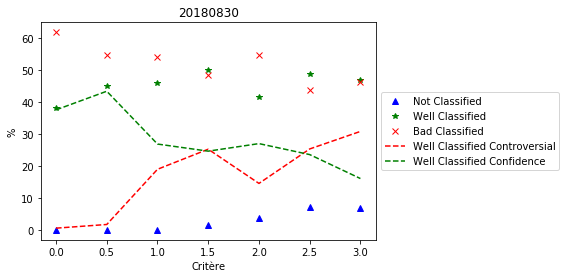

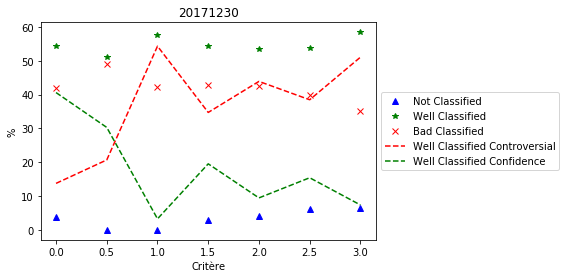

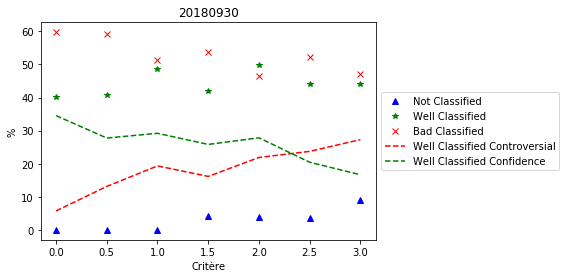

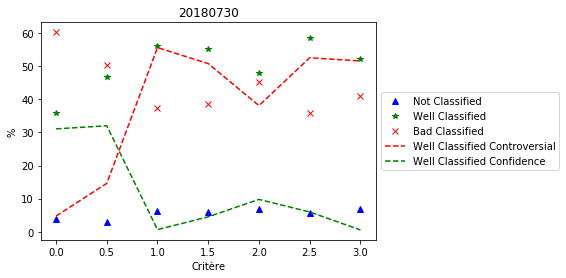

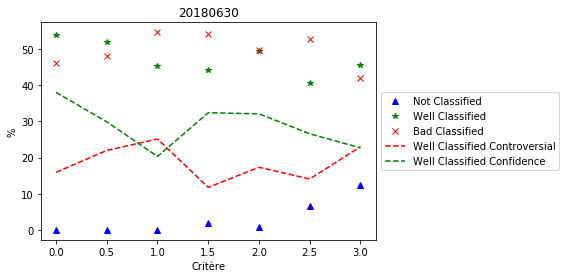

In [15]:
################################################  PARAMETERS  ###############################################################

date_liste=['20180830','20171230','20180930','20180730','20180630'] #list of days to study
f= 7 #nb of folds
list_critere= np.linspace(0, 3, num=7) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)

###############################################  ALGORITHME  ################################################################
df_res_total=pd.DataFrame()

for date in date_liste:
    list_not_classified=[];
    list_well_classified=[];
    list_well_classified_controversial=[]
    list_well_classified_confidence=[]
    list_bad_classified=[];

    file='graph_'+date+'.gexf'
    G=nx.read_gexf(file)
    G=normalization_graph(G);

    for critere in list_critere:
        mean_not_classified=0
        mean_well_classified=0
        mean_bad_classified=0
        mean_well_classified_controversial=0;
        mean_well_classified_confidence=0;

        for i in range (0,f):
            #print('f=',i,'et critere=',critere)
            [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)
            
            mean_not_classified+=not_classified/to_classify
            mean_well_classified_controversial+=well_classified_controversial/to_classify
            mean_well_classified_confidence+=well_classified_confidence/to_classify
            mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
            mean_bad_classified+=bad_classified/to_classify
            
            #Merge with df_res_total
#             df_res=df_res.set_index('WebsiteURL')
#             df_res.drop('Reference',1, inplace=True);
#             name=date+'- fold='+str(i)
#             df_res.rename(columns={'Found':name}, inplace=True)
#             df_res_total=pd.merge(df_res_total, df_res,how='outer') #,left_index=True, right_index=True) #, right_index=True, left_index=True
    

        list_not_classified.append(100*mean_not_classified/f)
        list_well_classified.append(100*mean_well_classified/f)
        list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
        list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
        list_bad_classified.append(100*mean_bad_classified/f)

    # plot graph
    plt.figure()
    
    plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
    plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
    plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
    plt.xlabel('Critère')
    plt.ylabel('%')
    
    plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
    plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(date)


## Conclusion
- The higher criteria, the higher number of not classified nodes,
- Need to have a high number of fold because very fluctuent (big graph with a lot of nodes)

# STUDY "OPTIMAL" CRITERIA RESULT

In [19]:
######################################## PARAMETRES ###################################################
date='20180830'
f=10;
critere=1.7;

################################## USEFULL VARIABLES ######################################################
confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unknown','unreliable','satire','hate','clickBait','clickbait','junksci','rumor','unreliable','state','controversial']

################################ FUNCTION ################################################################
file='graph_'+date+'.gexf'
G=nx.read_gexf(file)
    
df_res_total=pd.DataFrame();
for i in range (0,f):
    [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params)
    
    df_res=df_res.set_index('WebsiteURL')
    df_res.drop('Reference',1, inplace=True);
    df_res.rename(columns={'Found':i}, inplace=True)

    #Merge with df_res_total
    df_res_total=pd.merge(df_res_total, df_res,how='outer',left_index=True, right_index=True) #, right_index=True, left_index=True
    print(i)

0
1
2
3
4
5
6
7
8
9


In [20]:
#Count the most appearance type
list_c_type=[]
list_c_number=[]
list_confidence=[]
for index,row in df_res_total.iterrows():
    ligne=df_res_total.loc[index]
    columns=df_res_total.columns
    liste=[]
    for i in range (len(df_res_total.columns)):
        liste.append(ligne[i])
    c = Counter(liste)
    nb_nan=c[nan]
    if pd.isnull(c.most_common(1)[0][0]):                
        if c.most_common(1)[0][1]==len(df_res_total.columns):
            list_c_type.append('Not Classified')
            list_c_number.append(0)
            list_confidence.append(0)
        else:
            list_c_type.append(c.most_common(2)[1][0])
            list_c_number.append(c.most_common(2)[1][1])
            list_confidence.append(c.most_common(2)[1][1]/(len(df_res_total.columns)-nb_nan))
    else:
        list_c_type.append(c.most_common(1)[0][0])
        list_c_number.append(c.most_common(1)[0][1])
        list_confidence.append(c.most_common(1)[0][1]/(len(df_res_total.columns)-nb_nan))
        
df_res_total['Most appearance found type'] =list_c_type
df_res_total['Nb of appearance'] =list_c_number
df_res_total['Confidence'] =list_confidence

#Add reference column
fake_news_sources_df.index.names = ['WebsiteURL']
reference=fake_news_sources_df.type.to_frame()
df_res_total=pd.merge(df_res_total, reference, how='inner',left_index=True, right_index=True) 

df_res_total['type'].replace(confidence_type, 'confidence', inplace=True)
df_res_total['type'].replace(controversial_type, 'controversial', inplace=True)

In [21]:
df_res_total

,0,1,2,3,4,5,6,7,8,9,Most appearance found type,Nb of appearance,Confidence,type
WebsiteURL,,,,,,,,,,,,,,
advocate.com,NaN,NaN,NaN,NaN,NaN,confidence,controversial,confidence,NaN,confidence,confidence,3,0.750000,confidence
alternet.org,confidence,controversial,NaN,NaN,NaN,NaN,NaN,confidence,NaN,NaN,confidence,2,0.666667,confidence
americanthinker.com,NaN,controversial,NaN,confidence,NaN,NaN,controversial,confidence,confidence,NaN,confidence,3,0.600000,controversial
antiwar.com,confidence,NaN,NaN,confidence,confidence,confidence,NaN,confidence,confidence,confidence,confidence,7,1.000000,controversial
blacklistednews.com,NaN,NaN,NaN,NaN,confidence,NaN,NaN,NaN,NaN,NaN,confidence,1,1.000000,controversial
breitbart.com,NaN,NaN,controversial,confidence,NaN,NaN,controversial,NaN,NaN,NaN,controversial,2,0.666667,confidence
canadafreepress.com,NaN,NaN,controversial,NaN,confidence,NaN,NaN,NaN,NaN,NaN,controversial,1,0.500000,controversial
christianpost.com,NaN,NaN,NaN,confidence,NaN,NaN,controversial,confidence,confidence,NaN,confidence,3,0.750000,confidence
commentarymagazine.com,NaN,NaN,NaN,confidence,NaN,NaN,NaN,confidence,confidence,NaN,confidence,3,1.000000,confidence


In [22]:
#Print results
print('Number of well classified :',len(df_res_total[df_res_total['Most appearance found type']==df_res_total['type']]))
print('Number of not classified :',len(df_res_total[df_res_total['Most appearance found type'].isnull()]))
print('Number of bad classified:',len(df_res_total[df_res_total['Most appearance found type']!=df_res_total['type']])-len(df_res_total[df_res_total['Most appearance found type'].isnull()]))

Number of well classified : 34
Number of not classified : 0
Number of bad classified: 29


In [30]:
df_res_total['Most appearance found type'].replace([None], 'Not Classified', inplace=True)
df_confusion = pd.crosstab(df_res_total['type'], df_res_total['Most appearance found type'])

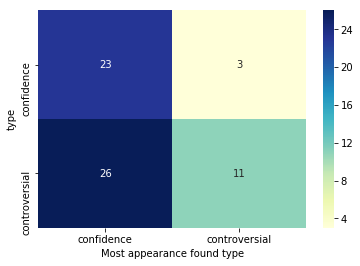

In [29]:
import seaborn as sns;
sns.heatmap(df_confusion, annot=True, cmap="YlGnBu")

Not very conclusive because there is no 'global' optimum criteria : there is a lot of errors with true controversial website that are classified as confidence one.

# TEST WITH 2 DAYS GRAPH

In [5]:
file = 'graph/graph_20170929_20170930.gexf'

f= 40 #nb of folds
list_critere= np.linspace(0, 5, num=7) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)

###############################################  ALGORITHME  ################################################################
df_res_total=pd.DataFrame()


list_not_classified=[];
list_well_classified=[];
list_well_classified_controversial=[]
list_well_classified_confidence=[]
list_bad_classified=[];

G=nx.read_gexf(file)
G=normalization_graph(G);

pbar = tqdm(total=len(list_critere)*f)


for critere in list_critere:
    mean_not_classified=0
    mean_well_classified=0
    mean_bad_classified=0
    mean_well_classified_controversial=0;
    mean_well_classified_confidence=0;

    for i in range (0,f):
        [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)

        mean_not_classified+=not_classified/to_classify
        mean_well_classified_controversial+=well_classified_controversial/to_classify
        mean_well_classified_confidence+=well_classified_confidence/to_classify
        mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
        mean_bad_classified+=bad_classified/to_classify
        pbar.update(1)

        #Merge with df_res_total
#             df_res=df_res.set_index('WebsiteURL')
#             df_res.drop('Reference',1, inplace=True);
#             name=date+'- fold='+str(i)
#             df_res.rename(columns={'Found':name}, inplace=True)
#             df_res_total=pd.merge(df_res_total, df_res,how='outer') #,left_index=True, right_index=True) #, right_index=True, left_index=True


    list_not_classified.append(100*mean_not_classified/f)
    list_well_classified.append(100*mean_well_classified/f)
    list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
    list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
    list_bad_classified.append(100*mean_bad_classified/f)

pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 280/280 [12:42<00:00,  2.72s/it]


NameError: name 'plt' is not defined

Text(0.5,1,'20170929 and 20170930')

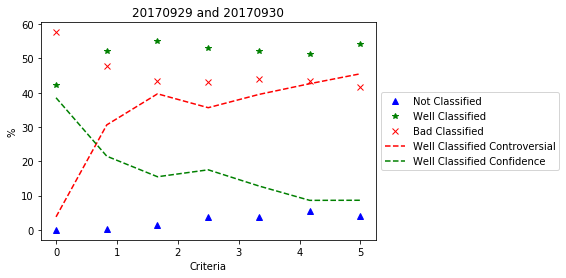

In [6]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
plt.xlabel('Criteria')
plt.ylabel('%')

plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('20170929 and 20170930')

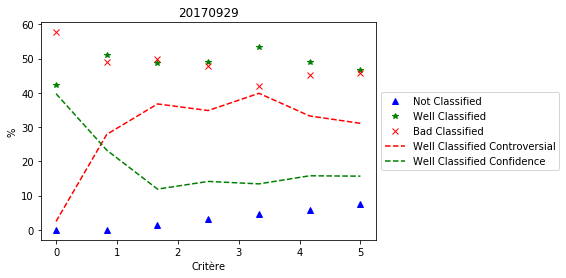

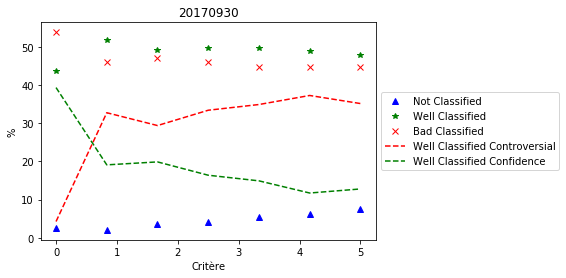

In [10]:
################################################  PARAMETERS  ###############################################################

date_liste=['20170929','20170930'] #list of days to study
f= 40 #nb of folds
list_critere= np.linspace(0, 5, num=7) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)

###############################################  ALGORITHME  ################################################################
df_res_total=pd.DataFrame()

for date in date_liste:
    list_not_classified=[];
    list_well_classified=[];
    list_well_classified_controversial=[]
    list_well_classified_confidence=[]
    list_bad_classified=[];

    file='graph/graph_'+date+'.gexf'
    G=nx.read_gexf(file)
    G=normalization_graph(G);

    for critere in list_critere:
        mean_not_classified=0
        mean_well_classified=0
        mean_bad_classified=0
        mean_well_classified_controversial=0;
        mean_well_classified_confidence=0;

        for i in range (0,f):
            #print('f=',i,'et critere=',critere)
            [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)
            
            mean_not_classified+=not_classified/to_classify
            mean_well_classified_controversial+=well_classified_controversial/to_classify
            mean_well_classified_confidence+=well_classified_confidence/to_classify
            mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
            mean_bad_classified+=bad_classified/to_classify
            
            #Merge with df_res_total
#             df_res=df_res.set_index('WebsiteURL')
#             df_res.drop('Reference',1, inplace=True);
#             name=date+'- fold='+str(i)
#             df_res.rename(columns={'Found':name}, inplace=True)
#             df_res_total=pd.merge(df_res_total, df_res,how='outer') #,left_index=True, right_index=True) #, right_index=True, left_index=True
    

        list_not_classified.append(100*mean_not_classified/f)
        list_well_classified.append(100*mean_well_classified/f)
        list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
        list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
        list_bad_classified.append(100*mean_bad_classified/f)

    # plot graph
    plt.figure()
    
    plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
    plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
    plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
    plt.xlabel('Critère')
    plt.ylabel('%')
    
    plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
    plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(date)


In [41]:
#convert to gephi graph to look at typesd
G=nx.read_gexf('graph/graph_20170929_20170930.gexf')
H=label_controversial_website(G,string=True)
nx.write_gexf(H,'graph_20170929_20170930_type.gexf')

Conclusion : result independent of the number of day in the graph.